In [207]:
import cv2
import numpy as np
from PIL import Image, ImageMath
import random
import albumentations as A
import matplotlib.pyplot as plt
import os
import time
import json


In [208]:
with open("/home/CenterPose/data/custom_box/custom_box_train/image_paths_train.txt") as f:
    image_paths = f.readlines()

In [209]:

# # 전체 이미지의 채널별 평균/표준편차를 저장할 배열 초기화  
# channel_pixels = [[] for _ in range(3)]

# # 모든 이미지에서 채널별 픽셀값 수집
# for image_path in image_paths:
#     image_path = image_path.strip()
#     image = cv2.imread(image_path)
    
#     # 각 채널의 모든 픽셀값을 해당 채널 배열에 추가
#     for i in range(3):
#         channel_pixels[i].extend(image[:,:,i].flatten())

# # 채널별 전체 평균과 표준편차 계산
# means = [np.mean(channel) for channel in channel_pixels]
# stds = [np.std(channel) for channel in channel_pixels]

# print('전체 이미지의 채널별 평균 (B,G,R):', means)
# print('전체 이미지의 채널별 표준편차 (B,G,R):', stds)

In [210]:
# means = np.array(means) / 255
# stds = np.array(stds) / 255
# print('전체 이미지의 채널별 평균 (B,G,R):', means)
# print('전체 이미지의 채널별 표준편차 (B,G,R):', stds)

In [211]:
random_image_path = random.choice(image_paths).strip()
random_json_path = random_image_path.replace('.jpg', '.json')
print(random_image_path)
print(random_json_path)

/home/custom_dataset/box_folders/box_blacktea_1/_output/0002.jpg
/home/custom_dataset/box_folders/box_blacktea_1/_output/0002.json


In [212]:
import lib.datasets.dataset_combined as dataset_combined
from lib.opts import opts
from lib.utils.image import flip, color_aug
from lib.utils.image import get_affine_transform, affine_transform
from lib.utils.image import gaussian_radius, draw_umich_gaussian, draw_msra_gaussian, draw_nvidia_gaussian
from lib.utils.image import draw_dense_reg

def rotation_y_matrix(theta):
    M_R = np.array([[np.cos(theta), 0, np.sin(theta), 0],
                    [0, 1, 0, 0],
                    [-np.sin(theta), 0, np.cos(theta), 0], [0, 0, 0, 1]])
    return M_R


def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)

    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]


def bounding_box_rotation(points, trans):
    coordinates_transformed = []
    for x, y, _ in points:
        coordinates_transformed.append(affine_transform([x, y], trans))

    return bounding_box(coordinates_transformed)

In [213]:
def change_background(img, mask, bg):
    # oh = img.height  
    # ow = img.width
    oh, ow = img.shape[:2]
    bg = cv2.resize(bg, (ow, oh))
    
    # Split channels
    img_channels = cv2.split(img)
    bg_channels = cv2.split(bg) 
    mask_channels = cv2.split(mask)
    
    # Create output channels
    out_channels = []
    
    # Blend each channel
    for c in range(3):
        neg_mask = 1 - mask_channels[c]/255.0
        pos_mask = mask_channels[c]/255.0
        blended = img_channels[c] * pos_mask + bg_channels[c] * neg_mask
        out_channels.append(blended.astype(np.uint8))
        
    # Merge channels
    out = cv2.merge(out_channels)
    
    return out


In [214]:
bg_paths = []
for root, dirs, files in os.walk("/mnt/SUN397/SUN397"):
    for file in files:
        if file.endswith(".jpg"):
            bg_paths.append(os.path.join(root, file))
print(len(bg_paths))


108754


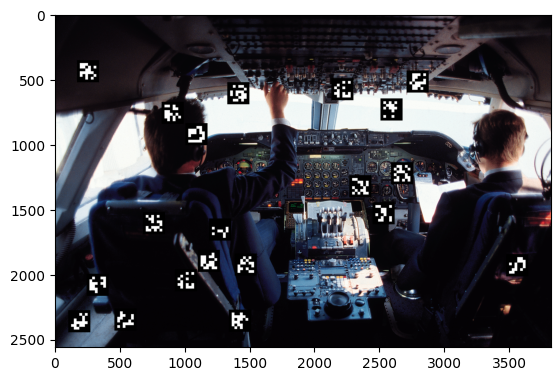

In [215]:

plt.imshow(bg)
plt.show()


In [216]:
from cv2 import aruco

marker_size = 200
dictionary = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
print(dictionary.bytesList.shape)
# 여러 마커 생성 및 저장
for marker_id in range(10):  # 0부터 9까지 10개의 마커 생성
    marker_image = aruco.generateImageMarker(dictionary, marker_id, marker_size)
    print(type(marker_image))
    print(marker_image.shape)
    # plt.imshow(marker_image)
    break

(250, 5, 4)
<class 'numpy.ndarray'>
(200, 200)


17


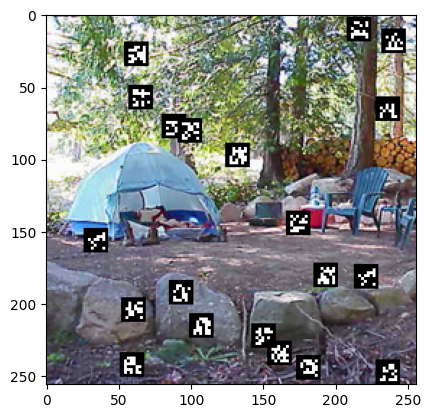

In [217]:
def add_aruco_markers_to_bg(bg, dictionary, num_markers=5):
    bg_height, bg_width = bg.shape[:2]
    marker_size = min(bg_height, bg_width) // 15
    print(marker_size)

    for _ in range(num_markers):
        marker_id = random.randint(0, dictionary.bytesList.shape[0] - 1)
        marker_image = aruco.generateImageMarker(dictionary, marker_id, marker_size)
        marker_image = np.repeat(marker_image[:, :, np.newaxis], 3, axis=2)
        
        # Random position for the marker
        x_offset = random.randint(0, bg_width - marker_size)
        y_offset = random.randint(0, bg_height - marker_size)
        
        # Insert the marker into the background
        bg[y_offset:y_offset + marker_size, x_offset:x_offset + marker_size] = marker_image
    
    return bg

random_bg_path = random.choice(bg_paths)
bg = np.array(Image.open(random_bg_path))

bg_with_markers = add_aruco_markers_to_bg(bg, dictionary, num_markers=20)

plt.imshow(bg_with_markers)
plt.show()

In [449]:
class MyDataset(dataset_combined.ObjectPoseDataset):
    def __init__(self, opt, split):
        super(MyDataset, self).__init__(opt, split)
        self.bg_paths = bg_paths
        self.aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_100)
    
    def _get_aug_param(self, c_ori, s, width, height, disturb=False):
        c = c_ori.copy()
        if (not self.opt.not_rand_crop) and not disturb:
            # Training for current frame
            # aug_s = np.random.choice(np.arange(0.6, 1.4, 0.1))
            aug_s = np.random.choice(np.arange(0.8, 1.2, 0.1))

            
            # w_border = self._get_border(256, width)
            # h_border = self._get_border(256, height)
            translate = 0.9
            w_border = self._get_border(int(width * translate), width)
            h_border = self._get_border(int(height * translate), height)
            
            c[0] = np.random.randint(low=w_border, high=width - w_border)
            c[1] = np.random.randint(low=h_border, high=height - h_border)
        else:
            # Training for previous frame
            sf = self.opt.scale
            cf = self.opt.shift

            c[0] += s * np.clip(np.random.randn() * cf, -2 * cf, 2 * cf)
            c[1] += s * np.clip(np.random.randn() * cf, -2 * cf, 2 * cf)
            aug_s = np.clip(np.random.randn() * sf + 1, 1 - sf, 1 + sf)

        # if np.random.random() < self.opt.aug_rot:
        if np.random.random() < 0.5:
            rf = self.opt.rotate  # 0 - 180
            rf = random.randint(0,180)  # 0 - 180

            rot = 2 * (np.random.rand() - 0.5) * rf
            # rot = np.clip(np.random.randn() * rf, -rf * 2, rf * 2)
        else:
            rot = 0

        return c, aug_s, rot
    
    def add_aruco_markers_to_bg(self, bg, dictionary, num_markers=5):
        bg_height, bg_width = bg.shape[:2]
        marker_size = min(bg_height, bg_width) // 15
        print(marker_size)

        for _ in range(num_markers):
            marker_id = random.randint(0, dictionary.bytesList.shape[0] - 1)
            marker_image = aruco.generateImageMarker(dictionary, marker_id, marker_size)
            marker_image = np.repeat(marker_image[:, :, np.newaxis], 3, axis=2)
            
            # Random position for the marker
            x_offset = random.randint(0, bg_width - marker_size)
            y_offset = random.randint(0, bg_height - marker_size)
            
            # Insert the marker into the background
            bg[y_offset:y_offset + marker_size, x_offset:x_offset + marker_size] = marker_image
        
        return bg
    
    def __getitem__(self, index):
        if not self.opt.custom:
            path_img, video_id, frame_id, path_json = self.images[index]
        else:
            path_img, _, _, path_json = self.images[index]
            video_id = 0
            frame_id = 0

        img_path = path_img
        with open(path_json) as f:
            anns = json.load(f)
        if not self.opt.custom:
            num_objs = min(len(anns['objects']), self.max_objs)
        else:
            num_objs = 1
            

        try:
            img = cv2.imread(img_path)
        except:
            return None

        if self.opt.new_data_augmentation:
            # Only apply albumentations on spatial data augmentation, nothing to do with gt label
            transform = A.Compose([
                A.MotionBlur(blur_limit=3, p=0.1),
                A.Downscale(scale_min=0.6, scale_max=0.8, p=0.1),
                A.GaussNoise(p=0.2),
                A.Blur(p=0.2),
                A.RandomBrightnessContrast(p=0.2),
            ],
            )
            transformed = transform(image=img)
            # Update image
            img = transformed["image"]

        try:
            height, width = img.shape[0], img.shape[1]
        except:
            return None
        c_ori = np.array([img.shape[1] / 2., img.shape[0] / 2.], dtype=np.float32)
        s_ori = max(img.shape[0], img.shape[1]) * 1.0
        rot = 0

        flipped = False
        if self.split == 'train':

            c, aug_s, rot = self._get_aug_param(c_ori, s_ori, width, height, disturb=False)
            s = s_ori * aug_s

            if np.random.random() < self.opt.flip:
                flipped = True
                img = img[:, ::-1, :]

                c[0] = width - c[0] - 1
        else:
            c = c_ori
            s = s_ori
        
        # c = c_ori
        
        print("c_ori", c_ori, "c", c, "s", s, "rot", rot, "width", width, "height", height)
        trans_input = get_affine_transform(
            c, s, rot, [self.opt.input_res, self.opt.input_res])

        try:
            # bg switch
            if self.opt.custom and self.split == 'train' :
                _ann = anns['labelingInfo'][0]['3DBox']
                _xy_dict = _ann["location"][0]
                _corner_order = [9,8,4,5,1,7,3,6,2]
                _label = [[int(_xy_dict[f"x{i}"]), int(_xy_dict[f"y{i}"])] for i in _corner_order]  
                _pts_ori = np.array(_label)
                if flipped:
                    _pts_ori[:, 0] = width - _pts_ori[:, 0] - 1
                _corners = _pts_ori[1:] # 8개의 코너 포인트

                # 정수형 좌표로 변환
                _corners = _corners.astype(np.int32)
                
                # 빈 마스크 생성 
                mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
                
                # 코너 포인트들로 다각형 그리기
                hull = cv2.convexHull(_corners)
                cv2.fillPoly(mask, [hull], 255)
                
                # 마스크를 3채널로 확장
                mask = mask[:,:,np.newaxis]
                mask = np.repeat(mask, 3, axis=2)
                # plt.imshow(mask)

                
                # bg = np.full((img.shape[0], img.shape[1], 3), [255, 0, 0], dtype=np.uint8)
                if np.random.random() < self.bg_ratio:
                    bg = random.choice(self.bg_imgs)
                    bg = np.array(bg.resize((img.shape[1], img.shape[0])))
                else:
                    bg = img.copy()

                print("bg", bg.shape)
                bg = self.add_aruco_markers_to_bg(bg, self.aruco_dict, num_markers=20)
                # plt.imshow(bg)
                img = self.change_background(img, mask, bg)
            inp = self._get_input(img, trans_input)
        except Exception as e:
            print("Error in __getitem__() (background switch?): ", e)
            return None
        plt.imshow(inp.transpose(1,2,0))

        output_res = self.opt.output_res
        num_joints = self.num_joints
        trans_output_rot = get_affine_transform(c, s, rot, [output_res, output_res])

        if not self.opt.custom :
            cam_projection_matrix = anns['camera_data']['camera_projection_matrix']
        for k in range(num_objs): # custom : num_objs = 1
            if not self.opt.custom : ann = anns['objects'][k]
            else : 
                ann = anns["labelingInfo"][k]["3DBox"]
                if path_json.split('/')[-3] == 'box_monitor_1':
                    ann['scale'] = self.dimension_ref_custom['box_monitor_1']
                elif path_json.split('/')[-3] == 'box_monitor_2':
                    ann['scale'] = self.dimension_ref_custom['box_monitor_2']
                elif path_json.split('/')[-3] == 'box_barcode_1':
                    ann['scale'] = self.dimension_ref_custom['box_barcode_1']
                elif path_json.split('/')[-3] == 'box_barcode_2':
                    ann['scale'] = self.dimension_ref_custom['box_barcode_2']
                elif path_json.split('/')[-3] == 'box_blacktea_1':
                    ann['scale'] = self.dimension_ref_custom['box_blacktea_1']
                elif path_json.split('/')[-3] == 'box_blacktea_2':
                    ann['scale'] = self.dimension_ref_custom['box_blacktea_2']
                elif path_json.split('/')[-3] == 'box_maxim_1':
                    ann['scale'] = self.dimension_ref_custom['box_maxim_1']
                elif path_json.split('/')[-3] == 'box_maxim_2':
                    ann['scale'] = self.dimension_ref_custom['box_maxim_2']
                elif path_json.split('/')[-3] == 'box_tea_1':
                    ann['scale'] = self.dimension_ref_custom['box_tea_1']
                elif path_json.split('/')[-3] == 'box_tea_2':
                    ann['scale'] = self.dimension_ref_custom['box_tea_2']
                elif path_json.split('/')[-3] == 'box_tissue_1':
                    ann['scale'] = self.dimension_ref_custom['box_tissue_1']
                elif path_json.split('/')[-3] == 'box_tissue_2':
                    ann['scale'] = self.dimension_ref_custom['box_tissue_2']

    
            if self.opt.custom : num_symmetry = 1
 
            # Todo: Fixed as 0 for now
            cls_id = 0
            if not self.opt.custom : pts_ori = np.array(ann['projected_cuboid'])
            else : 
                xy_dict = ann["location"][0]
                # label = [[int(xy_dict[f"x{i}"]), int(xy_dict[f"y{i}"])] for i in [9]+list(range(1, 9))]
                corner_order = [9,8,4,5,1,7,3,6,2]
                label = [[int(xy_dict[f"x{i}"]), int(xy_dict[f"y{i}"])] for i in corner_order]  

                pts_ori = np.array(label)

            # Only apply rotation on gt annotation when symmetry exists
            for id_symmetry in range(num_symmetry):

                ct_ori = pts_ori[0]  # center
                pts_ori = pts_ori[1:]  # 8 corners

                # Change visibility, following the protocol of COCO
                pts = np.zeros((len(pts_ori), 3), dtype='int64')
                for idx, p in enumerate(pts_ori):
                    if p[0] >= width or p[0] < 0 or p[1] < 0 or p[1] >= height:
                        pts[idx] = [p[0], p[1], 1]  # labeled but not visible
                    else:
                        pts[idx] = [p[0], p[1], 2]  # labeled and visible

                # Horizontal flip
                if flipped:
                    pts[:, 0] = width - pts[:, 0] - 1
                    for e in self.opt.flip_idx:
                        temp_1 = e[1] - 1
                        temp_0 = e[0] - 1
                        pts[temp_0], pts[temp_1] = pts[temp_1].copy(), pts[temp_0].copy()

                bbox = np.array(bounding_box_rotation(pts, trans_output_rot))

                bbox = np.clip(bbox, 0, output_res - 1)
                h, w = bbox[3] - bbox[1], bbox[2] - bbox[0]


In [450]:
import sys
sys.argv = [
    "program_name",
    "--load_model", 
    "/home/CenterPose/exp/object_pose/objectron_custom_box_dlav1_34_2024-10-18-06-50/custom_box_best.pth",
    "--resume"
]
# Default params with commandline input
opt = opts()
opt = opt.parser.parse_args()

# Local configuration
opt.c = 'custom_box'
opt.arch='dlav1_34'
opt.obj_scale = True
opt.obj_scale_weight = 1
opt.mug = False

# Training param
opt.exp_id = f'objectron_{opt.c}_{opt.arch}'
opt.num_epochs = 140
opt.val_intervals = 5
opt.lr_step = '90,120'
opt.batch_size = 16
opt.lr = 6e-5
opt.gpus = '0'
opt.num_workers = 4
opt.print_iter = 5
opt.debug = 5
opt.save_all = True

# # To continue
# opt.resume = True
# opt.load_model = ""

# Copy from parse function from opts.py
opt.gpus_str = opt.gpus
opt.gpus = [int(gpu) for gpu in opt.gpus.split(',')]
opt.gpus = [i for i in range(len(opt.gpus))] if opt.gpus[0] >= 0 else [-1]
opt.lr_step = [int(i) for i in opt.lr_step.split(',')]
opt.test_scales = [float(i) for i in opt.test_scales.split(',')]

opt.fix_res = not opt.keep_res
print('Fix size testing.' if opt.fix_res else 'Keep resolution testing.')
opt.reg_offset = not opt.not_reg_offset
opt.reg_bbox = not opt.not_reg_bbox
opt.hm_hp = not opt.not_hm_hp
opt.reg_hp_offset = (not opt.not_reg_hp_offset) and opt.hm_hp

if opt.head_conv == -1:  # init default head_conv
    opt.head_conv = 256 if 'dla' in opt.arch else 64
opt.pad = 127 if 'hourglass' in opt.arch else 31
opt.num_stacks = 2 if opt.arch == 'hourglass' else 1

if opt.trainval:
    opt.val_intervals = 100000000

if opt.master_batch_size == -1:
    opt.master_batch_size = opt.batch_size // len(opt.gpus)
rest_batch_size = (opt.batch_size - opt.master_batch_size)
opt.chunk_sizes = [opt.master_batch_size]
for i in range(len(opt.gpus) - 1):
    slave_chunk_size = rest_batch_size // (len(opt.gpus) - 1)
    if i < rest_batch_size % (len(opt.gpus) - 1):
        slave_chunk_size += 1
    opt.chunk_sizes.append(slave_chunk_size)
print('training chunk_sizes:', opt.chunk_sizes)

# opt.root_dir = os.path.join(os.path.dirname(__file__), '..') # CenterPose/
opt.root_dir = "/home/CenterPose/"
opt.data_dir = os.path.join(opt.root_dir, 'data') # CenterPose/data
opt.exp_dir = os.path.join(opt.root_dir, 'exp', opt.task) # CenterPose/exp/opt.task

time_str = time.strftime('%Y-%m-%d-%H-%M')
opt.save_dir = os.path.join(opt.exp_dir, f'{opt.exp_id}_{time_str}')
opt.debug_dir = os.path.join(opt.save_dir, 'debug')
print('The output will be saved to ', opt.save_dir)

# custom options
opt.custom = True
opt.num_workers = 0
opt.obj_scale_weight = 0
if opt.c == 'custom_box':
    opt.data_dir = '/home/CenterPose/data/custom_box'

Dataset = MyDataset

opt = opts().update_dataset_info_and_set_heads(opt, Dataset)

Fix size testing.
training chunk_sizes: [16]
The output will be saved to  /home/CenterPose/exp/object_pose/objectron_custom_box_dlav1_34_2024-11-25-06-29
heads {'hm': 1, 'wh': 2, 'hps': 16, 'reg': 2, 'hm_hp': 8, 'hp_offset': 2, 'scale': 3}


self.img_dir:  /home/CenterPose/data/custom_box/custom_box_train
Loaded train 155 samples
Creating video index!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9277782..2.494348].


random index 154
c_ori [960. 540.] c [974. 550.] s 1920.0 rot 0 width 1920 height 1080
bg (1080, 1920, 3)
72


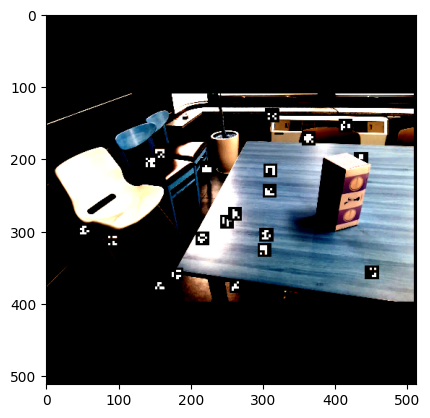

In [466]:
dataset = Dataset(opt, 'train')
random_index = random.randint(0, len(dataset)-1)
random_index = 154
print("random index", random_index)

item = dataset[random_index]